## DL model for Intel Classification
This is from one of the competition in Analytics Vidhya. Check the details [here](https://datahack.analyticsvidhya.com/contest/practice-problem-intel-scene-classification-challe/)

In [1]:
import numpy as np 
import pandas as pd 
from os import path
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

from keras import layers
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from keras.applications.imagenet_utils import preprocess_input
from keras.layers import Input, Dense, Activation, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, Lambda
from keras.models import Model
from keras.utils import np_utils,Sequence
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler,EarlyStopping,ModelCheckpoint

import keras.backend as K
from keras.models import Sequential

import warnings
warnings.simplefilter("ignore", category=DeprecationWarning)

%matplotlib inline

Using TensorFlow backend.


In [2]:
import tensorflow as tf
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

config = tf.ConfigProto()
# config.gpu_options.allocator_type = 'BFC'
tf.Session(config = config)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 15497673048807294385
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 3169819033
locality {
  bus_id: 1
  links {
  }
}
incarnation: 14619348343708583902
physical_device_desc: "device: 0, name: Quadro P1000, pci bus id: 0000:01:00.0, compute capability: 6.1"
]


In [3]:
images_dir = 'original_dataset/'
test = 'test_WyRytb0.csv'
train_dir = 'train/'
test_dir = 'test/'
labels = 'train.csv'
sample = 'sample_submission.csv'
IMG_SIZE = 150
batch_size = 4
train_split = 0.85

In [4]:
# All the labels for the training data
y_train = pd.read_csv(labels)
y_train.head()

,image_name,label
0,0.jpg,0
1,1.jpg,4
2,2.jpg,5
3,4.jpg,0
4,7.jpg,4


In [5]:
# This will help in preparing the images for test data
y_test = pd.read_csv(test)
y_test.head()

,image_name
0,3.jpg
1,5.jpg
2,6.jpg
3,11.jpg
4,14.jpg


In [6]:
#Here we have {'buildings' -> 0, 'forest' -> 1, 'glacier' -> 2, 'mountain' -> 3, 'sea' -> 4, 'street' -> 5 }
real_label = ['buildings','forest','glacier','mountain','sea','street']
frequency = []
freq_label = y_train['label'].value_counts()
for i in range(len(freq_label)):
    frequency.append(freq_label[i])

frequency

[2628, 2745, 2957, 3037, 2784, 2883]

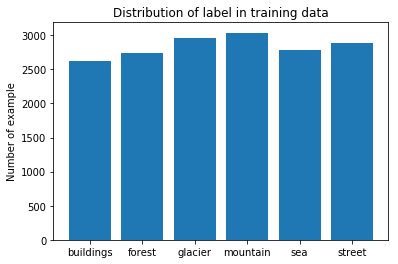

In [7]:
plt.bar(real_label,frequency)
#plt.xticks(real_label,frequency)
plt.ylabel('Number of example')
plt.title('Distribution of label in training data')

plt.show()

## Training and validation path
Reading all the images and saving the path given for the training in train_files and then splitting it into training and validation size. I have used 85-15 for splitting.
### Only run once below code

In [8]:
## Copy the image to train/val folder
#tqdm is a good way for presentation
import shutil
def copy_image(list_image,des_folder):
    for img in list_image['image_name']:
        path = os.path.join(images_dir,img)
        try:
            shutil.copy(path,des_folder)
        except shutil.Error as e:
            print('Error: %s' % e)
        except IOError as e:
            print('Error: %s' %e.strerror)

In [42]:
copy_image(y_train,train_dir)

In [43]:
copy_image(y_test,test_dir)

In [9]:
import glob

def load_img_paths(target,list_images):
    '''
    Retrieve the full path of all images given for training the network
    '''
    path = []
    for img in list_images['image_name']:
        path.append(glob.glob(target +img))
    return path

train_files = pd.DataFrame(load_img_paths(train_dir,y_train))

train_paths = []
train_paths = train_files[:][0].tolist()


#if train_split <= 1:
#    frac = int(train_files.shape[0] * train_split)
#    train_paths = train_files[:frac][0].tolist()
#    valid_paths = train_files[frac:][0].tolist()
#else:
#    valid_frac = int(train_split * valid_split)
#    train_paths = train_files[:train_split][0].values.tolist()
#    valid_paths = train_files[train_split:train_split+valid_frac][0].values.tolist()

assert(len(train_paths) > 0)
print('Training images:    %d' % len(train_paths))
#print('Validation images: %d' % len(valid_paths))

Training images:    17034


def prepareImages(data, m):
    print("Preparing images")
    X_train = np.zeros((m, 150, 150, 3))
    count = 0
    
    for fig in data['image_name']:
        #load images into images of size 150*150(original size)
        #src = cv2.imread("train/"+fig,)
        #img = cv2.cvtColor(src,cv2.COLOR_BGR2RGB)
        img = image.load_img("train/"+fig, target_size=(150, 150, 3))
        x = image.img_to_array(img)
        x = preprocess_input(x)
        X_train[count] = x
        count += 1
        if(count%1000==0):
            print('images done :',count)
    np.save('traindata.npy',X_train)
    return X_train

#If you already have npy file load that
#X_train = prepareImages(y_train,y_train.shape[0])
X_train = np.load('traindata.npy')
X_train /= 255

X_train.shape

In [10]:
# fix random seed for reproducibility
random_seed = 7
np.random.seed(random_seed)

## Converting Output into one hot code

A one hot encoding is a representation of categorical variables as binary vectors. This first requires that the categorical values be mapped to integer values. Then, each integer value is represented as a binary vector that is all zero values except the index of the integer, which is marked with a 1 and as this is a multi classification problem so we can convert the output class values into one-hot format which is simply a binary matrix, i.e.

value 0 will be converted to one-hot format as [1, 0, 0, 0, 0, 0, 0, 0, 0]

value 1 will be converted to one-hot format as [0, 1, 0, 0, 0, 0, 0, 0, 0] etc

Here we have {'buildings' -> 0, 'forest' -> 1, 'glacier' -> 2, 'mountain' -> 3, 'sea' -> 4, 'street' -> 5 }

In [11]:
# one hot encode outputs'
y_train_label = np_utils.to_categorical(y_train['label'])
num_classes = y_train_label.shape[1]
num_classes

6

In [12]:
# Separating out the image name to convert it into a dataframe with one hot encode output
y_train_imgname = y_train['image_name']

In [13]:
df_train_label = pd.DataFrame(y_train_label,columns=['Buildings','Forest','Glacier','Mountain','Sea','Street'])
df_train_label.head()

,Buildings,Forest,Glacier,Mountain,Sea,Street
0,1.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,1.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,1.0,0.0


In [14]:
df_train_label.insert(0,column='Image_name',value = y_train_imgname)
df_train_label.head()

,Image_name,Buildings,Forest,Glacier,Mountain,Sea,Street
0,0.jpg,1.0,0.0,0.0,0.0,0.0,0.0
1,1.jpg,0.0,0.0,0.0,0.0,1.0,0.0
2,2.jpg,0.0,0.0,0.0,0.0,0.0,1.0
3,4.jpg,1.0,0.0,0.0,0.0,0.0,0.0
4,7.jpg,0.0,0.0,0.0,0.0,1.0,0.0


In [15]:
y_map = {}
for ind, row in df_train_label.iterrows():
    _id = row['Image_name']
    y_map[_id] = row[1:]

In [16]:
y_map['10019.jpg']

Buildings    0
Forest       0
Glacier      0
Mountain     0
Sea          0
Street       1
Name: 6995, dtype: object

(150, 150, 3)

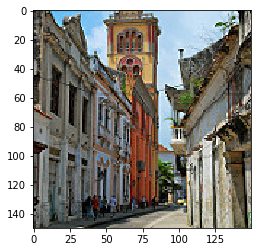

In [21]:
from skimage.io import imread
img_path = 'train/10019.jpg'
img = imread(img_path)
plt.imshow(img)
img.shape

# Build Model
I am using vgg16 like architecture for this problem

In [24]:
def ConvBlock(layers, model, num_filters):
    """
    Create a layered Conv/Pooling block
    """
    for i in range(layers):
        model.add(Conv2D(num_filters, (3, 3), activation='relu', padding='same')) # 3x3 filter size 
        
    model.add(MaxPooling2D((2,2), strides=(2,2),data_format='channels_first'))

def FCBlock(model, size=4096):
    """
    Fully connected block with ReLU and dropout
    """
    model.add(Dense(size, activation='relu'))
    model.add(Dropout(0.5))
    
def my_VGG16(input_shape):
    """
    Implement VGG16 architecture
    """
    model = Sequential()
    model.add(Lambda(lambda x : x, input_shape=input_shape))
    
    ConvBlock(2, model, 64)
    ConvBlock(2, model, 128)
    ConvBlock(3, model, 256)
    ConvBlock(3, model, 512)
    #ConvBlock(3, model, 512)

    model.add(Flatten())
    #FCBlock(model)
    FCBlock(model)

    model.add(Dense(6, activation = 'sigmoid'))
    return model

In [25]:
im_shape = (3,IMG_SIZE,IMG_SIZE)
# Then create the corresponding model 
my_model = my_VGG16(im_shape)
my_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
my_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_2 (Lambda)            (None, 3, 150, 150)       0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 3, 150, 64)        86464     
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 3, 150, 64)        36928     
_________________________________________________________________
max_pooling2d_3 (MaxPooling2 (None, 3, 75, 32)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 3, 75, 128)        36992     
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 3, 75, 128)        147584    
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 3, 37, 64)         0         
__________

## Data Augmentation
We will use data augmentation for increasing our dataset and avoid overfitting.

In [26]:
class DataGenerator(Sequence):
    '''
    Adapted from https://stanford.edu/~shervine/blog/keras-how-to-generate-data-on-the-fly.html
    Allows for multiprocessing in the fit generator
    '''

    def __init__(self, x_set, y_set, batch_size,shuffle=True):
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size
        self.shuffle = shuffle

    def __len__(self):
        return int(np.ceil(len(self.x) / float(self.batch_size)))

    def read_image(self,fname):
        return imread(fname).T    
    
    # Will output sequence of tuples (image, test) given a datapath
    def __getitem__(self, idx):
        X = np.zeros(shape=(batch_size, im_shape[0], im_shape[1], im_shape[2]))
        y = np.zeros(shape=(batch_size, 6))
        batch = self.x[idx * self.batch_size:(idx + 1) * self.batch_size]
        for j,fname in enumerate(batch):
            # load image from preprocessed images, much faster this way.
            image = self.read_image(fname)
            X[j] = img_to_array(image)
            file_id = path.split(fname)[1]
            y[j] = y_map[file_id]
        return (X, y)


class AugmentedDataGenerator(DataGenerator):
    '''
    Same as DataGenerator but augments data by overriding `read_image`.
    '''
    def flip_axis(self, x, axis):
        '''
        proper flip, skimage  flipud/lr acts funny on channels 
        from https://github.com/keras-team/keras/blob/master/keras/preprocessing/image.py#L323-L327
        '''
        x = np.asarray(x).swapaxes(axis, 0)
        x = x[::-1, ...]
        x = x.swapaxes(0, axis)
        return x

    def random_rotation(x):
        count = np.random.randint(0,4)
        out = np.ones((IMG_SIZE,IMG_SIZE,3))
        for i,channel in enumerate(x):
            out[i] = np.rot90(channel, count)
        return out
    
    def rand_augment(self, img):
        if np.random.randint(0,2):
            img = flip_axis(img, 1)
        if np.random.randint(0,2):
            img = flip_axis(img, 2)
        img = random_rotation(img)
        return img
    
    def read_image(fname):
        return self.rand_augment(imread(fname)).T

In [27]:
steps_per_epoch  = int(len(train_paths) / batch_size)
#validation_steps = int(len(valid_paths) / batch_size)

training_generator   = AugmentedDataGenerator(train_paths, y_map, batch_size)
#validation_generator = DataGenerator(valid_paths, y_map, batch_size)

print('Training images:    %d' % len(train_paths))
#print('Validation images: %d' % len(valid_paths))
print('Training steps:    %d' % steps_per_epoch)
#print('Validation steps:  %d' % validation_steps)

Training images:    17034
Training steps:    4258


## Train the model

In [28]:
# DECREASE LEARNING RATE EACH EPOCH
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.95 ** x)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='auto')
    
# descriptive weight file naming
checkpointer = ModelCheckpoint(filepath=('vgg16_1FC.h5'), 
                               verbose=1, save_best_only=True)

callbacks = [annealer,early_stopping,checkpointer]

In [29]:
hist = my_model.fit_generator(training_generator,
    epochs=50,
    verbose=1,
    steps_per_epoch = steps_per_epoch,
    callbacks=callbacks,
)

Epoch 1/50


TypeError: read_image() takes 1 positional argument but 2 were given

## To Do
Increase data using more data augmentation and also use binary__crossentropy in place of categorical for this multi label classification

In [52]:
from skimage.io import imread
x = imread('train/10.jpg').T


In [53]:
x.shape

(3, 150, 150)

In [47]:
y_map[path.split(train_paths[1])[1]]

Buildings    0
Forest       0
Glacier      0
Mountain     0
Sea          1
Street       0
Name: 1, dtype: object

In [14]:
model1.save_weights('model1_weights.h5')

## Predictions
Prepare the test Images and make the predictions

In [18]:
result = np.zeros((X_test.shape[0],1))
result = model1.predict(X_test)
result = np.argmax(result,axis=1)
result = pd.Series(result,name='label')
submission = pd.concat([y_test,result],axis = 1)
submission.to_csv("first_try.csv",index=False)